In [1]:
"""
What Andreas Wants:

Wants the postsyns to be binned up into the difference in orientation into 4 groups
Wants the same axons to be binned up into the receptive field groups
Want to find the 16 groups from those
Find the average number of shared segments for each of those
Put that in a pandas table and then plot the heatmap



"""

'\nWhat Andreas Wants:\n\nWants the postsyns to be binned up into the difference in orientation into 4 groups\nWants the same axons to be binned up into the receptive field groups\nWant to find the 16 groups from those\nFind the average number of shared segments for each of those\nPut that in a pandas table and then plot the heatmap\n\n\n\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [3]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
ndap100 = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [4]:
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

In [6]:
# set up bins for difference in prefered orientation 
rad2deg = 180/np.pi
ori_edges = np.linspace(0, np.pi /2 ,5) #maximum difference it can be is 90 degrees
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
print(oe)
ori_labels = list(zip(oe[:-1], oe[1:]))
print(ori_labels)
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 
print(ori_centers)

['0', '22', '45', '68', '90']
[('0', '22'), ('22', '45'), ('45', '68'), ('68', '90')]
[11.25 33.75 56.25 78.75]


# Get the data for the difference in orientation and the receptive field

In [10]:
radtune.BestVonFit.Unit()

segmentation segmentation id,vonbestfit_method method index,segment_id segment id unique within each Segmentation,von_hash unique hash for combination of sta analysis methods,base von mises baseline amplitude,thetas von mises gaussian peak angle (descending amp order),amps von mises gaussian amplitudes (descending amp order),sharps von mises gaussian sharpness (descending amp order),flat_pred predictive performance of flat mean,von_pred predictive performance of von fit on unshuffled data,shuff_pred predictive performance of von fit on shuffled data,von_pred_adv von mises predictive advantage over shuffled data,von_p_value fit component p_value by reshuffle,confidence confidence value that neuron is good match
3,1,648518346341351894,3975d5cb0692a185ecb12767aef38fda,0.00608233,=BLOB=,=BLOB=,=BLOB=,0.0174556,0.0169626,0.0171703,0.0118989,0.128,1.2574478737658663
3,1,648518346341352081,43e78ae3adb467d09adcde611f01448b,0.0,=BLOB=,=BLOB=,=BLOB=,0.0311313,0.0301053,0.0306913,0.0188241,0.043,0.6998166843236705
3,1,648518346341352891,2488ca428583222f70981b01e4b84c81,0.0142162,=BLOB=,=BLOB=,=BLOB=,0.0625723,0.0540431,0.0618035,0.124022,0.001,0.9393616940050551
3,1,648518346341353058,895593db7cc273e5c5dd26cf896f66a8,0.00875122,=BLOB=,=BLOB=,=BLOB=,0.023765,0.0229138,0.0234008,0.0204935,0.051,0.8768285929656696
3,1,648518346341353574,c534715cb303f36303087976793c693e,0.00190366,=BLOB=,=BLOB=,=BLOB=,0.00611624,0.00586693,0.00601307,0.0238947,0.048,0.8028348440847805
3,1,648518346341353607,c3d38bf4ff20237301abc2be2854bec2,0.00278173,=BLOB=,=BLOB=,=BLOB=,0.0127959,0.0124848,0.0124513,-0.00262496,0.371,1.0001903578961846
3,1,648518346341353788,50760dfb813b8bce1af6e30749d37957,0.00445278,=BLOB=,=BLOB=,=BLOB=,0.024403,0.0238272,0.0239218,0.00387628,0.284,1.1758365611109247
3,1,648518346341354313,456d0ce26cb3e874fbdee826f6baef4a,0.0,=BLOB=,=BLOB=,=BLOB=,0.00433999,0.0042463,0.00427842,0.00740099,0.192,0.7581695298671942
3,1,648518346341354496,9803cc33fe4974f7a0a44c2fbc2aa3d5,0.00593489,=BLOB=,=BLOB=,=BLOB=,0.00743922,0.00732635,0.00733592,0.00128631,0.345,0.6946624764497962
3,1,648518346341355048,e08338fb684f4a88bef613bf180b9ded,0.0206206,=BLOB=,=BLOB=,=BLOB=,0.0337921,0.0331177,0.0333157,0.00586001,0.205,0.72518372627392


In [ ]:
#looking at the different possible restrictions
is_tuned = 'von_r2>0.05 and von_pvalue<0.05'

In [32]:
# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.25' & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs_rf = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
spatconn_df_rf = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs_rf) * fc.SharedInput.proj(*attrs_rf, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())


In [42]:
len(sig_units_rf)

199

In [28]:
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.002' & tuned & segment
sig_unit_pairs_op = (sig_units_op.proj(segment_id1 = 'segment_id') * 
                 sig_units_op.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs_op = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
radconn_df_op = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs_op) * fc.SharedInput.proj(*attrs_op, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())

In [43]:
len(sig_units_op)

119

In [45]:
new_sig_units = sig_units_op & sig_units_rf
len(sig_units_op & sig_units_rf)

36

In [46]:
len(new_sig_units & pinky.PymeshfixDecimatedExcitatoryStitchedMesh())

23

In [ ]:
len(Decimation35OrphanStitched()),len(pinky.PymeshfixDecimatedExcitatoryStitchedMesh())

In [47]:
len(new_sig_units & pinky.Decimation35OrphanStitched())

13

In [ ]:
"""
***** look at the restriction which is removing a lot of the orphans ********
"""

In [61]:
""" now lets try combining them both into one table"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.002' & tuned & segment
sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.25' & segment
sig_units = sig_units_op & sig_units_rf
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                  sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
attrs = ['n_seg_shared']


spat_table = ((spattune.BestSTACorr & sig_unit_pairs).proj("union_corr_r2") * fc.SharedInput.proj(*attrs, segment_id1 = 'segment_id', segment_id2 = 'segment_b'))
total_table = spat_table*(radtune.BestVonCorr.proj("diff_pref_ori") & sig_unit_pairs)
total_table

df_rf_op = pd.DataFrame(total_table.fetch())
df_rf_op

# sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.002' & tuned & segment
# sig_unit_pairs_op = (sig_units_op.proj(segment_id1 = 'segment_id') * 
#                  sig_units_op.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

# attrs_op = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
# radconn_df_op = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs_op) * fc.SharedInput.proj(*attrs_op, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())

,sta_hash1,sta_hash2,apert_radius,segmentation,segment_id1,segment_id2,von_hash1,von_hash2,union_corr_r2,n_seg_shared,diff_pref_ori
0,327b5c6f642f79a6484bf70cf06c59d2,89419331b9dd5b88296b9ac324f2aa72,20,3,648518346341394813,648518346341400285,7ec91ddb035a32ff0996d986d94c82e7,f2a8fe7dbd3358248c5ff3d73122c116,0.026798,2,1.191730
1,327b5c6f642f79a6484bf70cf06c59d2,1911c94a970e6f83ec47c158720b44e3,20,3,648518346341394813,648518346341408348,7ec91ddb035a32ff0996d986d94c82e7,0d0c6d2b8c8485863dc7ff6190abb4be,-0.579450,1,0.159630
2,327b5c6f642f79a6484bf70cf06c59d2,a9a453997b3e786f076789c439459c07,20,3,648518346341394813,648518346341410817,7ec91ddb035a32ff0996d986d94c82e7,42e32b41cea1d6d5907ad8ae7b2ec431,0.533181,0,0.354459
3,327b5c6f642f79a6484bf70cf06c59d2,10a1c7cbde09b5b1ee60ff3add7bc8e1,20,3,648518346341394813,648518346342788331,7ec91ddb035a32ff0996d986d94c82e7,d15efca26c4602a284574cdf2b2cf34d,0.323947,0,0.802560
4,327b5c6f642f79a6484bf70cf06c59d2,16adfd9b6b4679c7b928824e366a96a7,20,3,648518346341394813,648518346342791293,7ec91ddb035a32ff0996d986d94c82e7,a5e9df338d3634cb79817df4cc8d806b,-0.001454,0,-1.289220
5,327b5c6f642f79a6484bf70cf06c59d2,cfc50cc35a2ac22f15cc2326712270bc,20,3,648518346341394813,648518346342798923,7ec91ddb035a32ff0996d986d94c82e7,b66dd1fb8f894dfc6b5f15407a0508e0,0.130175,2,-0.674671
6,327b5c6f642f79a6484bf70cf06c59d2,b415c7f2ebbfb0875bca5237cf187cc9,20,3,648518346341394813,648518346342806333,7ec91ddb035a32ff0996d986d94c82e7,c966e86d154a685d85ce18106fd5f98e,-0.393318,0,-1.017500
7,327b5c6f642f79a6484bf70cf06c59d2,4379c66f0b70df406d36f3bee269006e,20,3,648518346341394813,648518346342807966,7ec91ddb035a32ff0996d986d94c82e7,e9ab6947a0c0ffa6683b294d74b197fb,-0.385364,0,-1.054170
8,327b5c6f642f79a6484bf70cf06c59d2,781f528ea0494ff96cc55a30b4b094fc,20,3,648518346341394813,648518346342807971,7ec91ddb035a32ff0996d986d94c82e7,a86b79d67f42135072eb50a2504a04bc,0.123745,0,-1.342450
9,327b5c6f642f79a6484bf70cf06c59d2,f4a7a06ef3b9982970926f2c1ad68606,20,3,648518346341394813,648518346349462805,7ec91ddb035a32ff0996d986d94c82e7,5af91a0a17c5591d787c0722da025756,0.270992,0,-1.124990


In [62]:
"""
How to eventually find the bin of something
"""

"""
stores the bin center for the bin that the difference delongs in
np.digitize returns the bin index + 1 of the bin that the value would belong in
"""
df_rf_op['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(df_rf_op['diff_pref_ori']), ori_edges)) - 1]
df_rf_op

,sta_hash1,sta_hash2,apert_radius,segmentation,segment_id1,segment_id2,von_hash1,von_hash2,union_corr_r2,n_seg_shared,diff_pref_ori,bin_diff_pref_ori
0,327b5c6f642f79a6484bf70cf06c59d2,89419331b9dd5b88296b9ac324f2aa72,20,3,648518346341394813,648518346341400285,7ec91ddb035a32ff0996d986d94c82e7,f2a8fe7dbd3358248c5ff3d73122c116,0.026798,2,1.191730,78.75
1,327b5c6f642f79a6484bf70cf06c59d2,1911c94a970e6f83ec47c158720b44e3,20,3,648518346341394813,648518346341408348,7ec91ddb035a32ff0996d986d94c82e7,0d0c6d2b8c8485863dc7ff6190abb4be,-0.579450,1,0.159630,11.25
2,327b5c6f642f79a6484bf70cf06c59d2,a9a453997b3e786f076789c439459c07,20,3,648518346341394813,648518346341410817,7ec91ddb035a32ff0996d986d94c82e7,42e32b41cea1d6d5907ad8ae7b2ec431,0.533181,0,0.354459,11.25
3,327b5c6f642f79a6484bf70cf06c59d2,10a1c7cbde09b5b1ee60ff3add7bc8e1,20,3,648518346341394813,648518346342788331,7ec91ddb035a32ff0996d986d94c82e7,d15efca26c4602a284574cdf2b2cf34d,0.323947,0,0.802560,56.25
4,327b5c6f642f79a6484bf70cf06c59d2,16adfd9b6b4679c7b928824e366a96a7,20,3,648518346341394813,648518346342791293,7ec91ddb035a32ff0996d986d94c82e7,a5e9df338d3634cb79817df4cc8d806b,-0.001454,0,-1.289220,78.75
5,327b5c6f642f79a6484bf70cf06c59d2,cfc50cc35a2ac22f15cc2326712270bc,20,3,648518346341394813,648518346342798923,7ec91ddb035a32ff0996d986d94c82e7,b66dd1fb8f894dfc6b5f15407a0508e0,0.130175,2,-0.674671,33.75
6,327b5c6f642f79a6484bf70cf06c59d2,b415c7f2ebbfb0875bca5237cf187cc9,20,3,648518346341394813,648518346342806333,7ec91ddb035a32ff0996d986d94c82e7,c966e86d154a685d85ce18106fd5f98e,-0.393318,0,-1.017500,56.25
7,327b5c6f642f79a6484bf70cf06c59d2,4379c66f0b70df406d36f3bee269006e,20,3,648518346341394813,648518346342807966,7ec91ddb035a32ff0996d986d94c82e7,e9ab6947a0c0ffa6683b294d74b197fb,-0.385364,0,-1.054170,56.25
8,327b5c6f642f79a6484bf70cf06c59d2,781f528ea0494ff96cc55a30b4b094fc,20,3,648518346341394813,648518346342807971,7ec91ddb035a32ff0996d986d94c82e7,a86b79d67f42135072eb50a2504a04bc,0.123745,0,-1.342450,78.75
9,327b5c6f642f79a6484bf70cf06c59d2,f4a7a06ef3b9982970926f2c1ad68606,20,3,648518346341394813,648518346349462805,7ec91ddb035a32ff0996d986d94c82e7,5af91a0a17c5591d787c0722da025756,0.270992,0,-1.124990,56.25


In [63]:
# set up bins for `union_corr_r2`

union_edges = np.linspace(min(df_rf_op['union_corr_r2']), max(df_rf_op['union_corr_r2']), 6)
ue = list(['{:.2f}'.format(ee) for ee in union_edges])
union_labels = list(zip(ue[:-1], ue[1:]))
union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))
union_centers

array([  nan, -0.47, -0.14,  0.18,  0.51,  0.83,   nan])

In [64]:
# bin `union_corr_r2`
df_rf_op['bin_union_corr_r2'] = union_centers[(np.digitize(df_rf_op['union_corr_r2'], union_edges))]
df_rf_op

,sta_hash1,sta_hash2,apert_radius,segmentation,segment_id1,segment_id2,von_hash1,von_hash2,union_corr_r2,n_seg_shared,diff_pref_ori,bin_diff_pref_ori,bin_union_corr_r2
0,327b5c6f642f79a6484bf70cf06c59d2,89419331b9dd5b88296b9ac324f2aa72,20,3,648518346341394813,648518346341400285,7ec91ddb035a32ff0996d986d94c82e7,f2a8fe7dbd3358248c5ff3d73122c116,0.026798,2,1.191730,78.75,0.18
1,327b5c6f642f79a6484bf70cf06c59d2,1911c94a970e6f83ec47c158720b44e3,20,3,648518346341394813,648518346341408348,7ec91ddb035a32ff0996d986d94c82e7,0d0c6d2b8c8485863dc7ff6190abb4be,-0.579450,1,0.159630,11.25,-0.47
2,327b5c6f642f79a6484bf70cf06c59d2,a9a453997b3e786f076789c439459c07,20,3,648518346341394813,648518346341410817,7ec91ddb035a32ff0996d986d94c82e7,42e32b41cea1d6d5907ad8ae7b2ec431,0.533181,0,0.354459,11.25,0.51
3,327b5c6f642f79a6484bf70cf06c59d2,10a1c7cbde09b5b1ee60ff3add7bc8e1,20,3,648518346341394813,648518346342788331,7ec91ddb035a32ff0996d986d94c82e7,d15efca26c4602a284574cdf2b2cf34d,0.323947,0,0.802560,56.25,0.18
4,327b5c6f642f79a6484bf70cf06c59d2,16adfd9b6b4679c7b928824e366a96a7,20,3,648518346341394813,648518346342791293,7ec91ddb035a32ff0996d986d94c82e7,a5e9df338d3634cb79817df4cc8d806b,-0.001454,0,-1.289220,78.75,-0.14
5,327b5c6f642f79a6484bf70cf06c59d2,cfc50cc35a2ac22f15cc2326712270bc,20,3,648518346341394813,648518346342798923,7ec91ddb035a32ff0996d986d94c82e7,b66dd1fb8f894dfc6b5f15407a0508e0,0.130175,2,-0.674671,33.75,0.18
6,327b5c6f642f79a6484bf70cf06c59d2,b415c7f2ebbfb0875bca5237cf187cc9,20,3,648518346341394813,648518346342806333,7ec91ddb035a32ff0996d986d94c82e7,c966e86d154a685d85ce18106fd5f98e,-0.393318,0,-1.017500,56.25,-0.47
7,327b5c6f642f79a6484bf70cf06c59d2,4379c66f0b70df406d36f3bee269006e,20,3,648518346341394813,648518346342807966,7ec91ddb035a32ff0996d986d94c82e7,e9ab6947a0c0ffa6683b294d74b197fb,-0.385364,0,-1.054170,56.25,-0.47
8,327b5c6f642f79a6484bf70cf06c59d2,781f528ea0494ff96cc55a30b4b094fc,20,3,648518346341394813,648518346342807971,7ec91ddb035a32ff0996d986d94c82e7,a86b79d67f42135072eb50a2504a04bc,0.123745,0,-1.342450,78.75,0.18
9,327b5c6f642f79a6484bf70cf06c59d2,f4a7a06ef3b9982970926f2c1ad68606,20,3,648518346341394813,648518346349462805,7ec91ddb035a32ff0996d986d94c82e7,5af91a0a17c5591d787c0722da025756,0.270992,0,-1.124990,56.25,0.18


In [67]:
ori_name = "bin_diff_pref_ori"
rf_name = "bin_union_corr_r2"
#the possible centers
ori_centers, union_centers

(array([11.25, 33.75, 56.25, 78.75]),
 array([  nan, -0.47, -0.14,  0.18,  0.51,  0.83,   nan]))

In [75]:
new_df = df_rf_op.loc[df_rf_op[ori_name] == 11.25]
new_df_2 = new_df.loc[new_df[rf_name] == 0.18]
new_df_2

#find the average of the number of shared segments
current_median = new_df_2["n_seg_shared"].median()
current_median

5.0

In [85]:
orientation_diff = []
receptive_field = []
median_shared_segments = []
mean_shared_segments = []
for op_value in ori_centers:
    for rf_value in union_centers[1:-1]:
        orientation_diff.append(op_value)
        receptive_field.append(rf_value)
        
        new_df = df_rf_op.loc[df_rf_op[ori_name] == op_value]
        new_df_2 = new_df.loc[new_df[rf_name] == rf_value]

        #find the average of the number of shared segments
        current_median = new_df_2["n_seg_shared"].median()
        median_shared_segments.append(current_median)
        current_mean = new_df_2["n_seg_shared"].mean()
        mean_shared_segments.append(current_mean)

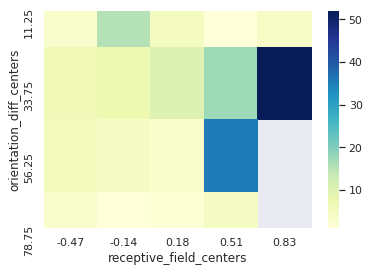

In [87]:
#actually plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
data_median_shared_syn = dict(orientation_diff_centers=orientation_diff,
                   receptive_field_centers=receptive_field,
                    median_shared_segments=median_shared_segments,
                   )

df_median_shared_syn = pd.DataFrame.from_dict(data_median_shared_syn)
df_median_shared_syn = df_median_shared_syn.pivot("orientation_diff_centers","receptive_field_centers","median_shared_segments") 
sns.heatmap(df_median_shared_syn, cmap="plasma")


In [ ]:
"""
Changes to make:
1) Normalize to the number 
"""

In [ ]:
#actually plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
data_median_shared_syn = dict(orientation_diff_centers=orientation_diff,
                   receptive_field_centers=receptive_field,
                    median_shared_segments=median_shared_segments,
                   )

df_median_shared_syn = pd.DataFrame.from_dict(data_median_shared_syn)
df_median_shared_syn = df_median_shared_syn.pivot("orientation_diff_centers","receptive_field_centers","median_shared_segments") 
sns.heatmap(df_median_shared_syn, cmap="plasma")

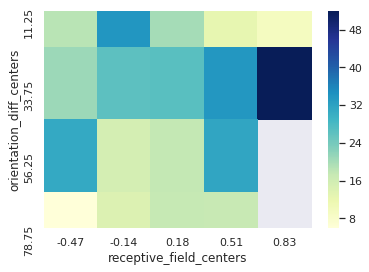

In [88]:
#actually plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
data_mean_shared_syn = dict(orientation_diff_centers=orientation_diff,
                   receptive_field_centers=receptive_field,
                    mean_shared_segments=mean_shared_segments,
                   )

df_mean_shared_syn = pd.DataFrame.from_dict(data_mean_shared_syn)
df_mean_shared_syn = df_mean_shared_syn.pivot("orientation_diff_centers","receptive_field_centers","mean_shared_segments") 
sns.heatmap(df_mean_shared_syn, cmap="YlGnBu")


In [ ]:
# How Fabian did his plots
"""
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2, ax=ax_heat)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
g.set_xticklabels(cbin_labels, rotation=30)
g.invert_yaxis()
g.tick_params(length=0)
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')"""